In [1]:
# autoreload nangs
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
#imports
import math
import numpy as np 
import matplotlib.pyplot as plt 
import torch

In [3]:
from nangs.pde import PDE
from nangs.bocos import PeriodicBoco, DirichletBoco, NeumannBoco
from nangs.solutions import MLP

class MyPDE(PDE):
    def __init__(self, inputs=None, outputs=None, order=2):
        super().__init__(inputs, outputs, order=order)
    def computePDELoss(self, grads, inputs, outputs, params): 
        dpdt = grads['p']['t']
        d2pdx2 = grads['2p']['xx']
        return [dpdt - d2pdx2]
    
# instanciate pde
pde = MyPDE(inputs=['x', 't'], outputs=['p'])

# define input values
x = np.linspace(0, 1, 10)

t = np.linspace(0, 10, 10)

pde.setValues({'x': x, 't': t})

In [4]:
# initial condition (dirichlet for temporal dimension)
p0 = np.full(len(x[1:-1]), 0)       
boco = DirichletBoco('initial_condition', {'x': x[1:-1], 't': np.array([0])}, {'p': p0})
pde.addBoco(boco)



boco = DirichletBoco('left', {'x': x[:1], 't': t}, {'p': np.full(len(t), 0.0)})
pde.addBoco(boco)

boco = DirichletBoco('right', {'x': x[-1:], 't': t}, {'p': np.full(len(t), 1.0)})
pde.addBoco(boco)

In [5]:
# define solution topology
mlp = MLP(pde.n_inputs, pde.n_outputs, 5, 256)
optimizer = torch.optim.Adam(mlp.parameters(), lr=3e-4)
pde.compile(mlp, optimizer)

In [6]:
# find the solution
hist = pde.solve(epochs=50) 

/home/sebastianm/.local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/sebastianm/.local/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


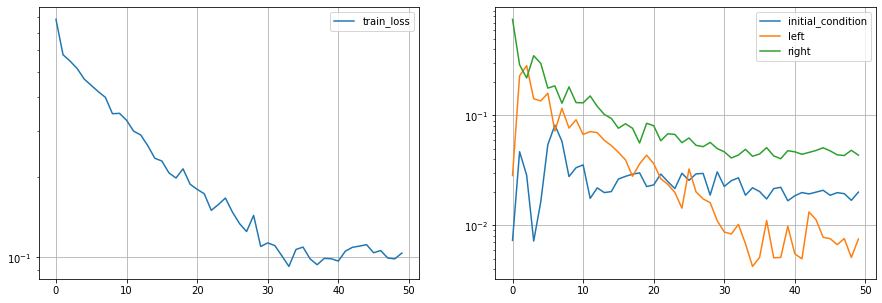

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
ax1.plot(hist['train_loss'], label="train_loss")
ax1.grid(True)
ax1.legend()
ax1.set_yscale("log")
for boco in pde.bocos:
    ax2.plot(hist['bocos'][boco.name], label=boco.name)
ax2.legend()
ax2.grid(True)
ax2.set_yscale("log")
plt.show()

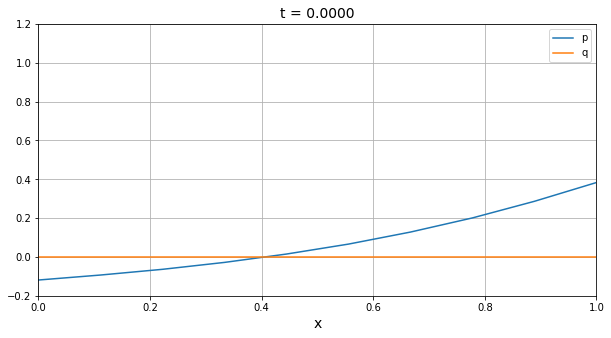

In [34]:
# evaluate the solution
x = np.linspace(0, 1, 10)

t = np.linspace(0, 10, 10)
p = []
for _t in t:
    pde.evaluate({'x': x, 't': np.array([_t])})
    _p = pde.outputs['p']
    p.append(_p)

rows, cols = (10, 10) 
q = [[0]*cols]*rows 
for e in range(0, 10):
    for f in range(0, 10):
        q[e][f] = np.sin(math.pi * f * 0.1 / 2.0) * math.exp(-math.pi**2 * e / 4)


from matplotlib import animation, rc
rc('animation', html='html5')

def plot(x, p, q, t):
    ax.clear()
    tit = ax.set_title(f"t = {t:.4f}", fontsize=14)
    ax.plot(x, p, label="p")
    ax.plot(x, q, label="q")
    ax.set_xlabel("x", fontsize=14)
    ax.legend(loc="upper right")
    ax.grid(True)
    ax.set_xlim([0, 1])
    ax.set_ylim([-0.2, 1.2])
    return [tit]

def get_anim(fig, ax, x, p, q, t):
    def anim(i):
        return plot(x, p[i], q[i], t[i])
    return anim

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111, autoscale_on=False)
animate = get_anim(fig, ax, x, p, q, t)
anim = animation.FuncAnimation(fig, animate, frames=len(t), interval=100, blit=True)






In [35]:
anim